In [1002]:
import pandas as pd
import seaborn as sns
import time
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore")

In [1003]:
train_set_end_idx = 30000  # give a default value to split train and test dataset


def read_data():
    train_data_url = './adult.data'
    test_data_url = './adult.test'
    columns_name = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
                    'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
                    'hours_per_week', 'native_country', 'income']
    # train dataset
    train_set = pd.read_csv(train_data_url, names=columns_name)
    global train_set_end_idx
    train_set_end_idx = len(train_set)
    # the first line of test data set is not valid, skip it
    test_set = pd.read_csv(test_data_url, names=columns_name, skiprows=1)
    set = pd.concat([train_set, test_set], ignore_index=True)
    return set

# General Analysis

In [1026]:
set = read_data()
train_set = set[:train_set_end_idx]
test_set = set[train_set_end_idx:]
set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education_num   48842 non-null  int64 
 5   marital_status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital_gain    48842 non-null  int64 
 11  capital_loss    48842 non-null  int64 
 12  hours_per_week  48842 non-null  int64 
 13  native_country  48842 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [1005]:
set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Exploratory Data Analysis

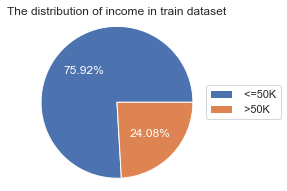

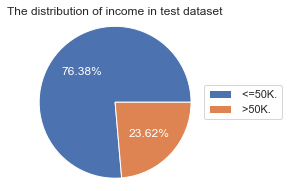

In [1006]:

# Get the distribution of income in train dataset
count_income = train_set['income'].value_counts()
plt.figure(figsize=(3, 3))
plt.title("The distribution of income in train dataset")
plt.pie(count_income, labels=count_income.index, autopct='%1.2f%%',
        textprops={'color': 'white'})
plt.axis('equal')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

count_income = test_set['income'].value_counts()
plt.figure(figsize=(3, 3))
plt.title("The distribution of income in test dataset")
plt.pie(count_income, labels=count_income.index, autopct='%1.2f%%',
        textprops={'color': 'white'})
plt.axis('equal')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

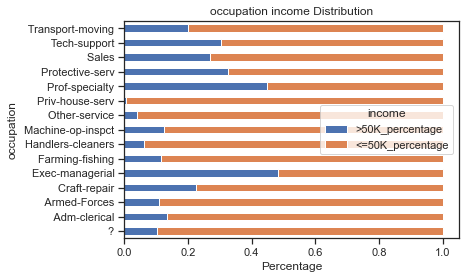

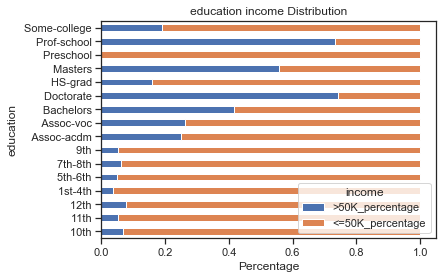

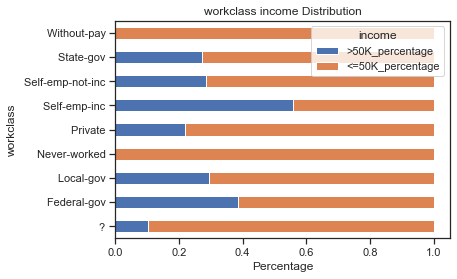

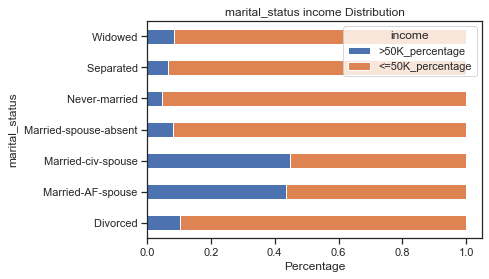

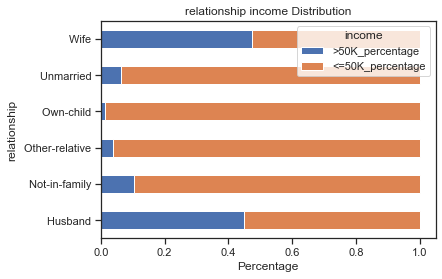

In [1007]:
for col in ['occupation', 'education', 'workclass', 'marital_status', 'relationship']:
    stat = train_set.groupby(col)['income'].value_counts().unstack()
    stat['total'] = stat.sum(axis=1)

    stat['>50K_percentage'] = stat[' >50K'] / stat['total']
    stat['<=50K_percentage'] = stat[' <=50K'] / stat['total']

    stat[['>50K_percentage', '<=50K_percentage']].plot(kind='barh', stacked=True)
    plt.title(col + ' income Distribution')
    plt.xlabel('Percentage')
    plt.ylabel(col)
    plt.show()

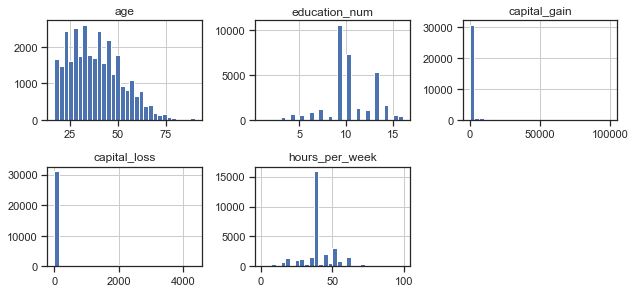

In [1008]:
analysis_cols = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
train_set[analysis_cols].hist(bins=30, figsize=(9, 6), layout=(3, 3))
plt.tight_layout()
plt.show()

<Figure size 576x576 with 0 Axes>

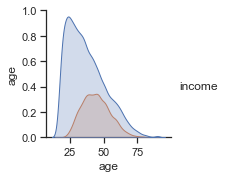

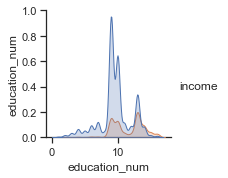

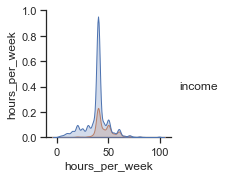

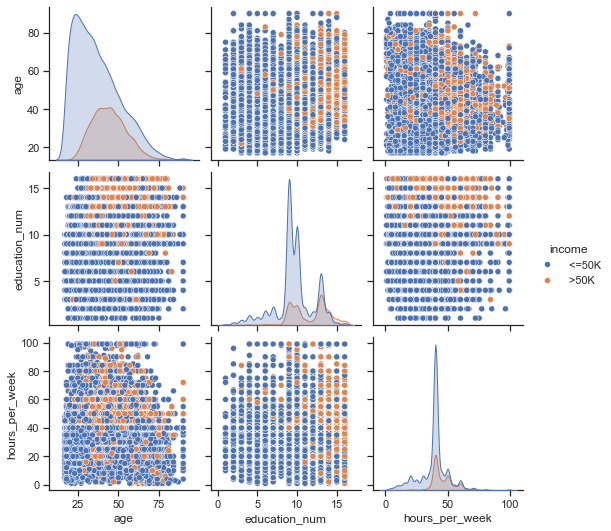

In [1029]:
plt.figure(figsize=(8, 8))
for i in ['age', 'education_num', 'hours_per_week']:
    pairplot = sns.pairplot(train_set, hue='income', vars=[i])
pairplot = sns.pairplot(train_set, hue='income', vars=['age', 'education_num', 'hours_per_week'])
plt.show()

# Data preprocessing

In [1010]:
# Checking missing value before preprocessing
print('Train Set Size: ')
print(len(train_set))
print("\n")
missing_values = train_set.isin([' ?']).sum()
print('Train Set Missing Value Check')
print(missing_values)
print('\n')


Train Set Size: 
32561


Train Set Missing Value Check
age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64




In [1011]:
def pre_process(set):
    # 1. drop columns which are not useful
    set.drop('fnlwgt', axis=1, inplace=True)
    
    # 2. fill missing values
    
    # set a default value for unknown column
    set.loc[set['native_country'].isin([' ?']), 'native_country'] = 'unknown'
    set.loc[set['workclass'].isin([' ?']), 'workclass'] = 'unknown'
    set.loc[set['occupation'].isin([' ?']), 'occupation'] = 'unknown'
    
    set.loc[set['workclass'] == 'Never-worked', 'occupation'] = 'No Employee'
    
    # 3. divide age into buckets based on data analysis
    bins = [0, 21, 30, 40, 50, 61, set['age'].max()]
    labels = ['<=21', '22-30', '31-40', '41-50', '50-61', '61+']
    set['age_set'] = pd.cut(set['age'], bins=bins, labels=labels)
    set = set.drop('age', axis=1)
    
    # 4. divide education_num into buckets based on data analysis
    bins = [0, 8, 12, set['education_num'].max()]
    labels = ['0-8', '9-11', '12+']
    set['education_num_set'] = pd.cut(set['education_num'], bins=bins, labels=labels)
    set = set.drop('education_num', axis=1)
    
    
    # 5. divide hours_per_week into buckets based on data analysis
    bins = [0, 15, 30, 40, set['hours_per_week'].max()]
    labels = ['0-15', '16-30', '31-40', '40+']
    set['hours_per_week_set'] = pd.cut(set['hours_per_week'], bins=bins, labels=labels)
    set = set.drop('hours_per_week', axis=1)
    
    
    return set

In [1012]:
train_set = pre_process(train_set)
test_set = pre_process(test_set)

In [1013]:
def one_hot_vector_and_label(set):
    One_Hot_Encoder = OneHotEncoder(sparse_output=False)
    onehot_cols = ['workclass', 'education', 'marital_status', 'occupation', 'education_num_set', 'relationship', 'race', 'sex',
                   'age_set', 'hours_per_week_set', 'capital_loss', 'capital_gain', 'native_country']
    onehot_encoded = One_Hot_Encoder.fit_transform(set[onehot_cols])
    set_one_hot = pd.DataFrame(onehot_encoded, columns=One_Hot_Encoder.get_feature_names_out(onehot_cols))

    labels = [0 if '<=50K' in x else 1 for x in set['income'].values]

    return set_one_hot, labels

## Model

### Logistic Regression

In [1014]:
from skopt.space import Real, Categorical, Integer
import numpy as np
from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

np.int = int

warnings.filterwarnings("ignore")
def logistic_regression_classification_best_params_search():
    # declare args grid
    param_space = [
    {
        'logreg__penalty': Categorical(['l2', None]),
        'logreg__solver': Categorical(['lbfgs', 'newton-cg', 'sag']),
        #'logreg__C': Real(0.001, 100, prior='log-uniform'),
        'logreg__class_weight': Categorical(['balanced', None]),
        'logreg__max_iter': Integer(100, 300)
    },
    {
        'logreg__penalty': Categorical(['l1']),
        'logreg__solver': Categorical(['liblinear', 'saga']),
        #'logreg__C': Real(0.001, 100, prior='log-uniform'),
        'logreg__class_weight': Categorical(['balanced', None]),
        'logreg__max_iter': Integer(100, 300)
    }
]
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression())
    ])

    opt = BayesSearchCV(
        pipe,
        param_space,
        n_iter=1,   #n_iter=50
        cv=5,
        n_jobs=-1,
    )
    
    all_set = pre_process(read_data())
    x, y = one_hot_vector_and_label(all_set)
    train_set, train_set_label = x[:train_set_end_idx], y[:train_set_end_idx]
    opt.fit(train_set, train_set_label)

    print("Best Parameters: ", opt.best_params_)


logistic_regression_classification_best_params_search()


/Users/sherry/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sherry/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sherry/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sherry/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sherry/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Parameters:  OrderedDict([('logreg__class_weight', None), ('logreg__max_iter', 226), ('logreg__penalty', 'l1'), ('logreg__solver', 'saga')])


Logistic Regression Run Time is:  13425.513982772827 ms
Logistic Regression test acc is  0.872550826116332 

Logistic Regression test report : 

              precision    recall  f1-score   support

           0       0.89      0.94      0.92     12435
           1       0.78      0.64      0.70      3846

    accuracy                           0.87     16281
   macro avg       0.84      0.79      0.81     16281
weighted avg       0.87      0.87      0.87     16281



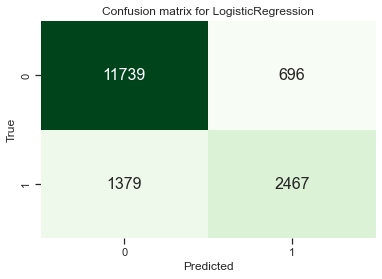

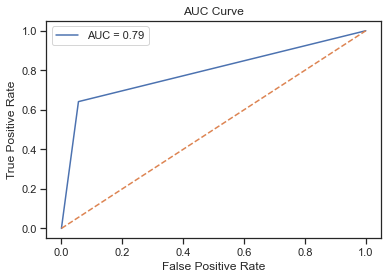

In [1018]:
from matplotlib.colors import ListedColormap


def logistic_regression_classification():
    all_set = pre_process(read_data())
    x, y = one_hot_vector_and_label(all_set)
    start_time = time.time()
    model = LogisticRegression(solver='saga', max_iter=226, penalty='l1', class_weight=None)
    #model = LogisticRegression(solver='liblinear', max_iter=249, penalty='l1', class_weight=None)
    train_set, train_set_label = x[:train_set_end_idx], y[:train_set_end_idx]
    model.fit(train_set, train_set_label)
    end_time = time.time() 
    print("Logistic Regression Run Time is: ", (end_time - start_time) * 1000, "ms")
    # verify the performance in test dataset
    test_set, test_set_label = x[train_set_end_idx:], y[train_set_end_idx:]
    pred_acc = model.score(test_set, test_set_label)
    print('Logistic Regression test acc is ', pred_acc, '\n')
    print('Logistic Regression test report : \n')
    print(classification_report(test_set_label, model.predict(test_set)))
    cm = confusion_matrix(test_set_label, model.predict(test_set))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, annot_kws={"size": 16})
    plt.title('Confusion matrix for LogisticRegression')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Display the plot
    plt.show()
    
    fpr, tpr, thresholds = roc_curve(test_set_label, model.predict(test_set))
    auc_score = roc_auc_score(test_set_label, model.predict(test_set))

    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC Curve')
    plt.legend()
    plt.show()


logistic_regression_classification()

### Decision Tree

Best Accuracy  0.8602051471039862 with depth  11


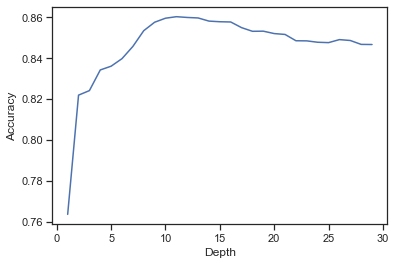

In [1022]:
def decision_tree_best_arg_search():
    all_set = pre_process(read_data())
    x, y = one_hot_vector_and_label(all_set)
    train_set, train_set_label = x[:train_set_end_idx], y[:train_set_end_idx]
    test_set, test_set_label = x[train_set_end_idx:], y[train_set_end_idx:]
    depths = []
    max_acc = 0
    max_depth = 0
    for i in range(1, 30):
        model = DecisionTreeClassifier(criterion="gini", max_depth=i, splitter="best")
        model.fit(train_set, train_set_label)
        pred_acc = model.score(test_set, test_set_label)
        depths.append(pred_acc)
        if pred_acc > max_acc:
            max_acc = pred_acc
            max_depth = i

    print("Best Accuracy ", max_acc, "with depth ", max_depth)
    plt.plot(range(1, 30), depths)
    plt.xlabel('Depth')
    plt.ylabel('Accuracy')
    plt.show()


decision_tree_best_arg_search()

Decision Tree Run Time is:  233.53290557861328 ms
Decision Tree test acc is  0.8603279896812235 

Decision Tree test report : 

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     12435
           1       0.77      0.58      0.66      3846

    accuracy                           0.86     16281
   macro avg       0.83      0.76      0.79     16281
weighted avg       0.85      0.86      0.85     16281

Decision Tree confusion matrix : 



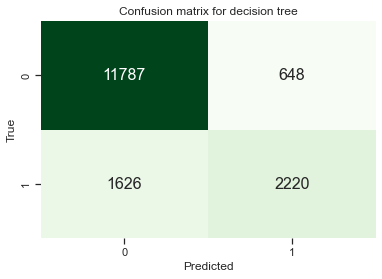

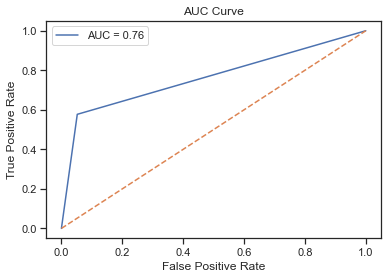

In [1024]:

def best_decision_tree():
    all_set = pre_process(read_data())
    x, y = one_hot_vector_and_label(all_set)
    train_set, train_set_label = x[:train_set_end_idx], y[:train_set_end_idx]
    start_time = time.time()  
    model = DecisionTreeClassifier(max_depth=11)
    model.fit(train_set, train_set_label)
    end_time = time.time() 
    print("Decision Tree Run Time is: ", (end_time - start_time) * 1000, "ms")
    test_set, test_set_label = x[train_set_end_idx:], y[train_set_end_idx:]
    pred_acc = model.score(test_set, test_set_label)
    print('Decision Tree test acc is ', pred_acc, '\n')
    print('Decision Tree test report : \n')
    print(classification_report(test_set_label, model.predict(test_set)))
    print('Decision Tree confusion matrix : \n')
    cm = confusion_matrix(test_set_label, model.predict(test_set))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, annot_kws={"size": 16})
    plt.title('Confusion matrix for decision tree')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    fpr, tpr, thresholds = roc_curve(test_set_label, model.predict(test_set))
    auc_score = roc_auc_score(test_set_label, model.predict(test_set))

    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC Curve')
    plt.legend()
    plt.show()


best_decision_tree()